In [1]:
# Instala librerías necesarias
!pip install torch


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa las librerías necesarias
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

### A - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,5,5,1]

### I - Grilla de 5 x 5:

Época 0, Pérdida total: 0.7517198324203491
Época 10, Pérdida total: 0.247693732380867
Época 20, Pérdida total: 0.11081476509571075
Época 30, Pérdida total: 0.06700243055820465
Época 40, Pérdida total: 0.05421433597803116
Época 50, Pérdida total: 0.04971865192055702
Época 60, Pérdida total: 0.0470535047352314
Época 70, Pérdida total: 0.043607115745544434
Época 80, Pérdida total: 0.04022867605090141
Época 90, Pérdida total: 0.037173956632614136
Época 100, Pérdida total: 0.03426007926464081
Época 110, Pérdida total: 0.031287942081689835
Época 120, Pérdida total: 0.028126293793320656
Época 130, Pérdida total: 0.024633368477225304
Época 140, Pérdida total: 0.020777948200702667
Época 150, Pérdida total: 0.01677517406642437
Época 160, Pérdida total: 0.013096194714307785
Época 170, Pérdida total: 0.010210336185991764
Época 180, Pérdida total: 0.0083073815330863
Época 190, Pérdida total: 0.007247581612318754
Época 200, Pérdida total: 0.006697554606944323
Época 210, Pérdida total: 0.006363711319

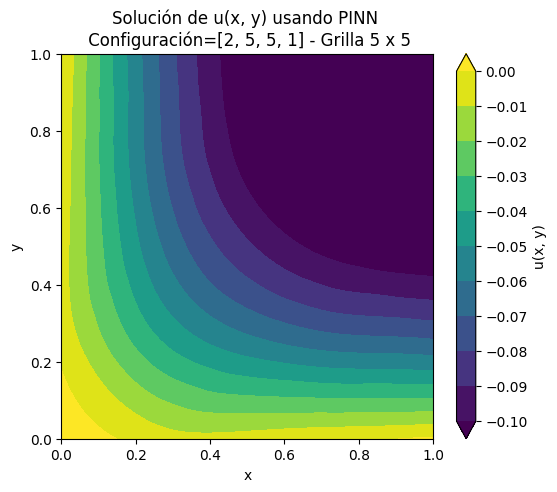

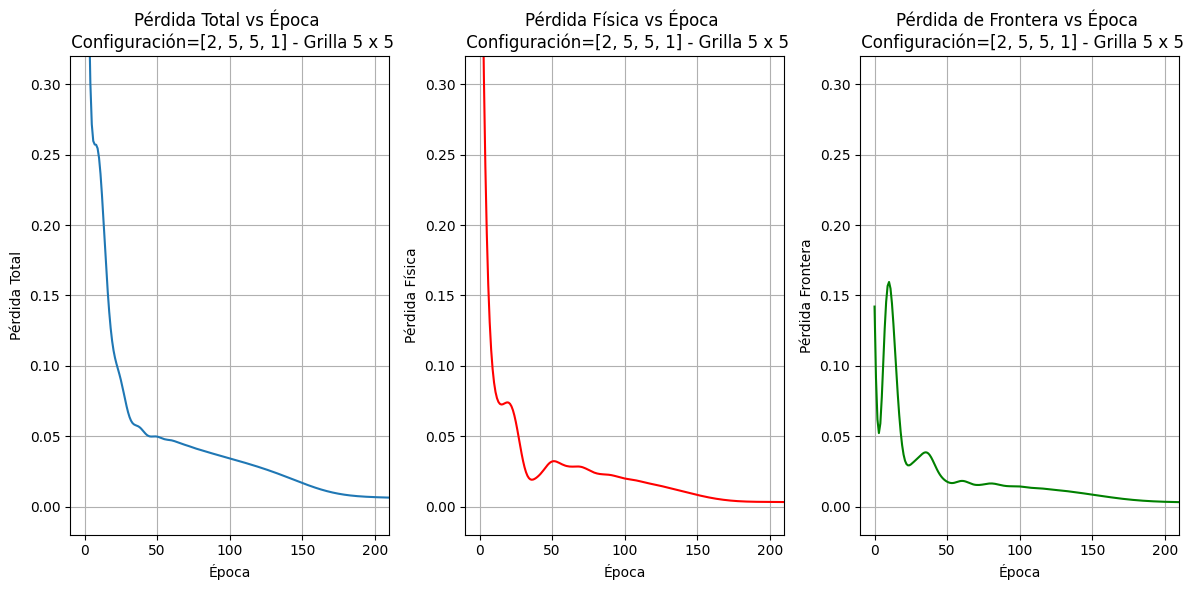

In [6]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear la grilla de puntos de entrenamiento
x_vals = np.linspace(0, 1, 5)
y_vals = np.linspace(0, 1, 5)
x, y = np.meshgrid(x_vals, y_vals)
xy_interior = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype=torch.float32, requires_grad=True)

# Crear puntos de la frontera
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 10 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con interpolación en grilla 1000 x 1000
def plot_solution_contourf(u_pred):
    # Crear grilla original de puntos 5x5
    x_vals = np.linspace(0, 1, 5)
    y_vals = np.linspace(0, 1, 5)
    x, y = np.meshgrid(x_vals, y_vals)

    # Crear grilla densa de 1000x1000
    x_dense = np.linspace(0, 1, 1000)
    y_dense = np.linspace(0, 1, 1000)
    x_dense_grid, y_dense_grid = np.meshgrid(x_dense, y_dense)

    # Interpolar la solución
    u_dense = griddata((x.ravel(), y.ravel()), u_pred.ravel(), (x_dense_grid, y_dense_grid), method='cubic')

    # Graficar
    plt.figure(figsize=(6, 5))
    cp = plt.contourf(x_dense, y_dense, u_dense, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos de la cuadrícula interior
with torch.no_grad():
    u_pred = model(xy_interior).numpy()

# Graficar la solución con contourf
plot_solution_contourf(u_pred)

# Graficar las pérdidas
plot_losses()

### II - Grilla de 10 x 10:

Época 0, Pérdida total: 0.36222538352012634
Época 10, Pérdida total: 0.19980858266353607
Época 20, Pérdida total: 0.11533977836370468
Época 30, Pérdida total: 0.040240656584501266
Época 40, Pérdida total: 0.028629764914512634
Época 50, Pérdida total: 0.023094983771443367
Época 60, Pérdida total: 0.018253283575177193
Época 70, Pérdida total: 0.014267226681113243
Época 80, Pérdida total: 0.01137272734194994
Época 90, Pérdida total: 0.009070763364434242
Época 100, Pérdida total: 0.007654888555407524
Época 110, Pérdida total: 0.006985219195485115
Época 120, Pérdida total: 0.006506003905087709
Época 130, Pérdida total: 0.006069940514862537
Época 140, Pérdida total: 0.005694148130714893
Época 150, Pérdida total: 0.00536283478140831
Época 160, Pérdida total: 0.005059455055743456
Época 170, Pérdida total: 0.004784905351698399
Época 180, Pérdida total: 0.004542071837931871
Época 190, Pérdida total: 0.004334209021180868
Época 200, Pérdida total: 0.00416099838912487
Época 210, Pérdida total: 0.00

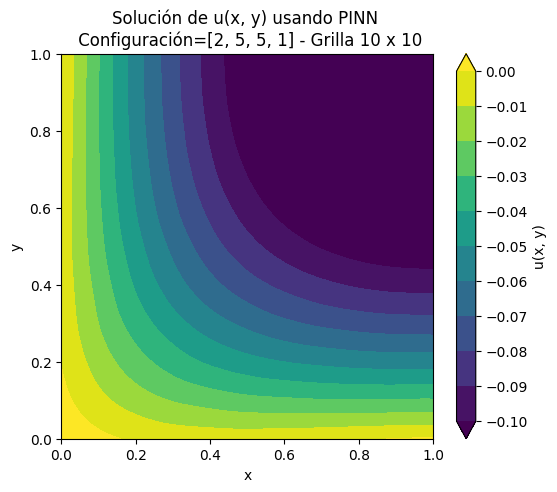

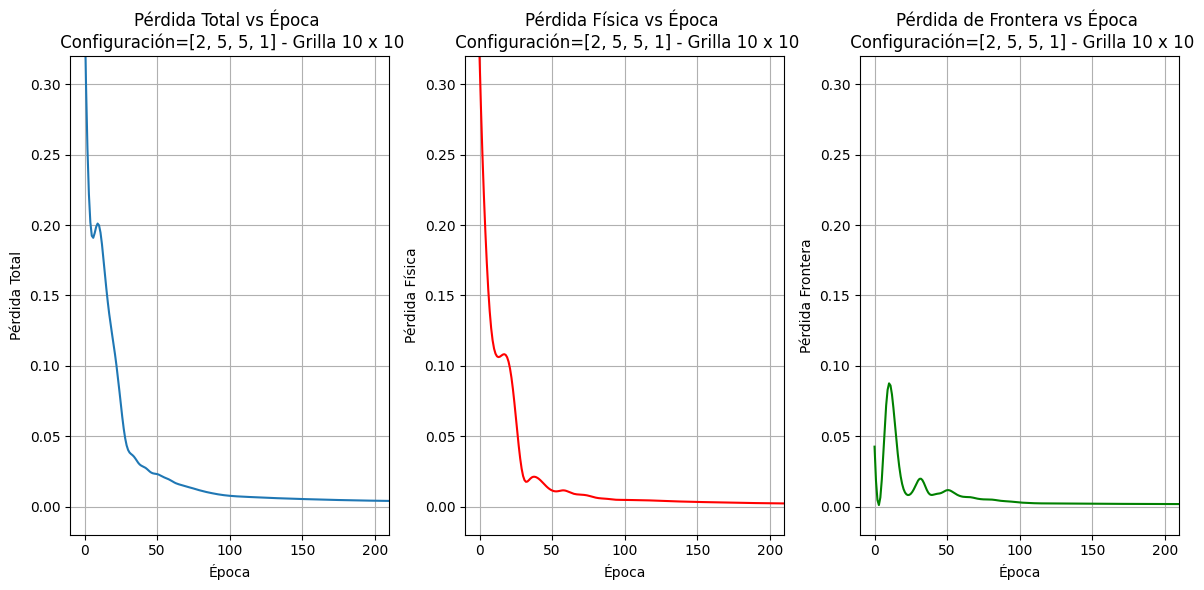

In [7]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear la grilla de puntos de entrenamiento (10x10)
x_vals = np.linspace(0, 1, 10)
y_vals = np.linspace(0, 1, 10)
x, y = np.meshgrid(x_vals, y_vals)
xy_interior = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype=torch.float32, requires_grad=True)

# Crear puntos de la frontera
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 10 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con interpolación en grilla 1000 x 1000
def plot_solution_contourf(u_pred):
    # Crear grilla original de puntos 10x10
    x_vals = np.linspace(0, 1, 10)
    y_vals = np.linspace(0, 1, 10)
    x, y = np.meshgrid(x_vals, y_vals)

    # Crear grilla densa de 1000x1000
    x_dense = np.linspace(0, 1, 1000)
    y_dense = np.linspace(0, 1, 1000)
    x_dense_grid, y_dense_grid = np.meshgrid(x_dense, y_dense)

    # Interpolar la solución
    u_dense = griddata((x.ravel(), y.ravel()), u_pred.ravel(), (x_dense_grid, y_dense_grid), method='cubic')

    # Graficar
    plt.figure(figsize=(6, 5))
    cp = plt.contourf(x_dense, y_dense, u_dense, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos de la cuadrícula interior
with torch.no_grad():
    u_pred = model(xy_interior).numpy()

# Graficar la solución con contourf
plot_solution_contourf(u_pred)

# Graficar las pérdidas
plot_losses()

### III - Grilla de 20 x 20:

Época 0, Pérdida total: 0.6942306756973267
Época 10, Pérdida total: 0.23305058479309082
Época 20, Pérdida total: 0.1117589995265007
Época 30, Pérdida total: 0.05546874180436134
Época 40, Pérdida total: 0.04975167289376259
Época 50, Pérdida total: 0.04190993681550026
Época 60, Pérdida total: 0.03865000233054161
Época 70, Pérdida total: 0.03614424914121628
Época 80, Pérdida total: 0.03390832990407944
Época 90, Pérdida total: 0.031836364418268204
Época 100, Pérdida total: 0.029876001179218292
Época 110, Pérdida total: 0.02791956439614296
Época 120, Pérdida total: 0.025939609855413437
Época 130, Pérdida total: 0.023786654695868492
Época 140, Pérdida total: 0.021210597828030586
Época 150, Pérdida total: 0.01783476397395134
Época 160, Pérdida total: 0.013556761667132378
Época 170, Pérdida total: 0.009531534276902676
Época 180, Pérdida total: 0.007345807272940874
Época 190, Pérdida total: 0.0064384532161056995
Época 200, Pérdida total: 0.005835137329995632
Época 210, Pérdida total: 0.00541733

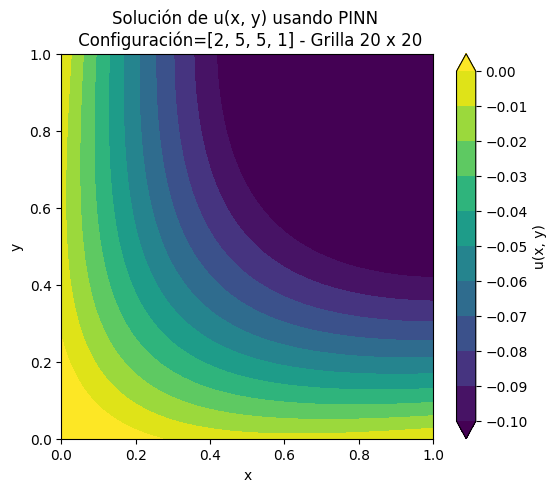

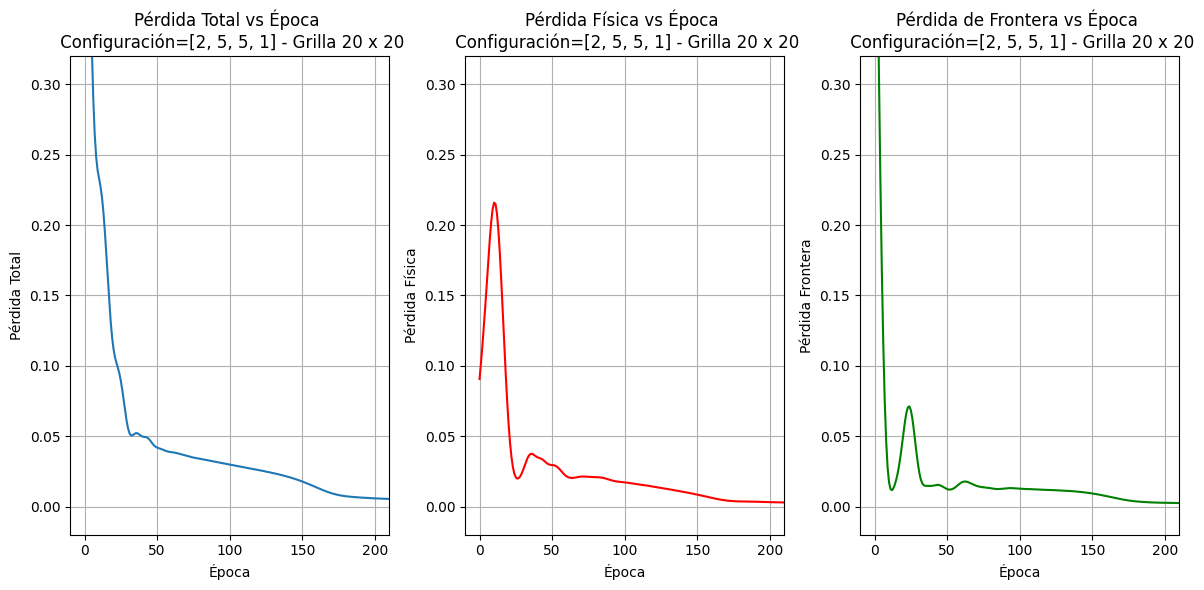

In [8]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear la grilla de puntos de entrenamiento (20x20)
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)
x, y = np.meshgrid(x_vals, y_vals)
xy_interior = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype=torch.float32, requires_grad=True)

# Crear puntos de la frontera
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 10 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con interpolación en grilla 1000 x 1000
def plot_solution_contourf(u_pred):
    # Crear grilla original de puntos 20x20
    x_vals = np.linspace(0, 1, 20)
    y_vals = np.linspace(0, 1, 20)
    x, y = np.meshgrid(x_vals, y_vals)

    # Crear grilla densa de 1000x1000
    x_dense = np.linspace(0, 1, 1000)
    y_dense = np.linspace(0, 1, 1000)
    x_dense_grid, y_dense_grid = np.meshgrid(x_dense, y_dense)

    # Interpolar la solución
    u_dense = griddata((x.ravel(), y.ravel()), u_pred.ravel(), (x_dense_grid, y_dense_grid), method='cubic')

    # Graficar
    plt.figure(figsize=(6, 5))
    cp = plt.contourf(x_dense, y_dense, u_dense, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos de la cuadrícula interior
with torch.no_grad():
    u_pred = model(xy_interior).numpy()

# Graficar la solución con contourf
plot_solution_contourf(u_pred)

# Graficar las pérdidas
plot_losses()

## B - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,5,5,1] utilizando muestreos aleatorios de los puntos de colocación.

### I - Cantidad de puntos de colocación aleatorios equivalente a grilla de 5x5.

Época 0, Pérdida total: 0.43550845980644226
Época 10, Pérdida total: 0.040782712399959564
Época 20, Pérdida total: 0.029787909239530563
Época 30, Pérdida total: 0.011885651387274265
Época 40, Pérdida total: 0.005496321711689234
Época 50, Pérdida total: 0.004889864940196276
Época 60, Pérdida total: 0.00437650503590703
Época 70, Pérdida total: 0.003977740183472633
Época 80, Pérdida total: 0.0037998149637132883
Época 90, Pérdida total: 0.003663521260023117
Época 100, Pérdida total: 0.0035529949236661196
Época 110, Pérdida total: 0.003437530715018511
Época 120, Pérdida total: 0.003322189673781395
Época 130, Pérdida total: 0.0032051673624664545
Época 140, Pérdida total: 0.003085141070187092
Época 150, Pérdida total: 0.0029613736551254988
Época 160, Pérdida total: 0.002832812489941716
Época 170, Pérdida total: 0.002698205877095461
Época 180, Pérdida total: 0.002556092105805874
Época 190, Pérdida total: 0.002404964528977871
Época 200, Pérdida total: 0.0022434168495237827
Época 210, Pérdida to

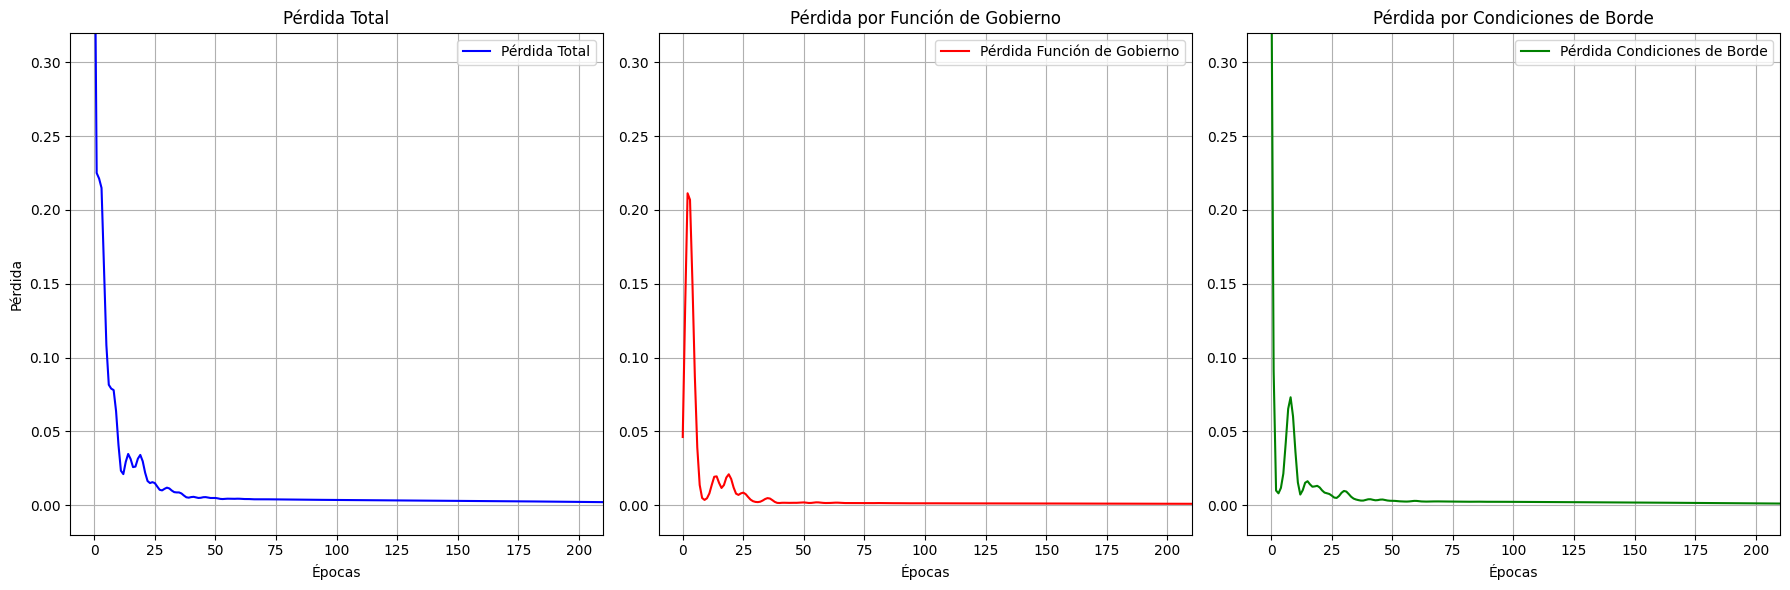

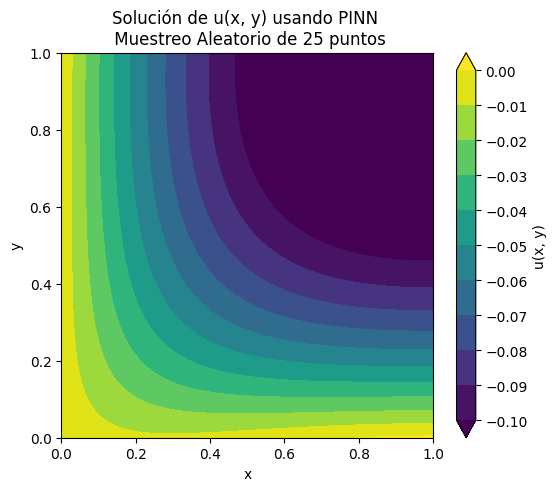

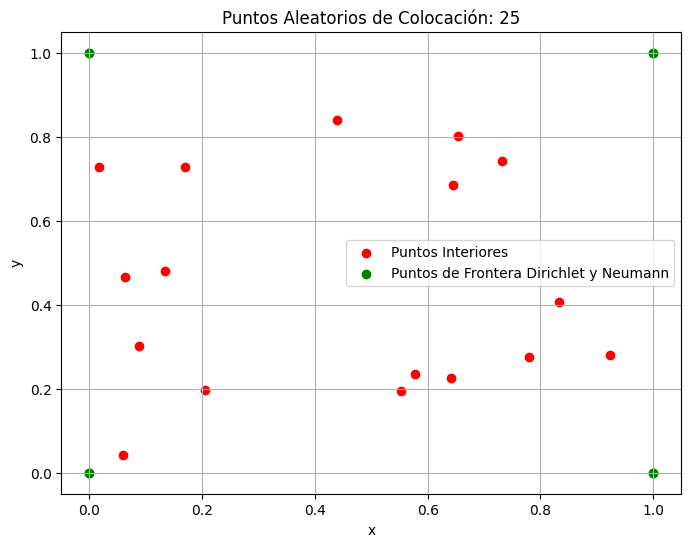

In [14]:
# Definición de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.model(x)

# Función de pérdida para el interior
def loss_fn(xy_interior):
    u = model(xy_interior)
    u_x = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_xx = torch.autograd.grad(u_x, xy_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, xy_interior, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    return torch.mean((laplace_u - source_term) ** 2)


# Función de pérdida para las condiciones de frontera
def boundary_loss(xy_boundary, boundary_type):
    u_boundary = model(xy_boundary)
    if boundary_type == "Dirichlet":
        return torch.mean((u_boundary) ** 2)
    elif boundary_type == "Neumann_x":
        u_x = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 0]
        return torch.mean((u_x) ** 2)
    elif boundary_type == "Neumann_y":
        u_y = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 1]
        return torch.mean((u_y) ** 2)

# Crear puntos del dominio
num_samples = 25  # Total de puntos
num_boundary_samples = int(0.32 * num_samples)  # 32% para la frontera
num_interior_samples = num_samples - num_boundary_samples  # 68% para el interior

# Crear puntos interiores
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras
x_vals = np.linspace(0, 1, 2)
y_vals = np.linspace(0, 1, 2)

xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)

# Crear el modelo y el optimizador
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 2000
losses_total = []
losses_interior = []
losses_boundary = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdida en el interior del dominio (función de gobierno)
    loss_interior = loss_fn(xy_interior_random)
    
    # Pérdidas de frontera (sin discriminar tipo)
    loss_boundary = (
        boundary_loss(xy_b0, "Dirichlet") +
        boundary_loss(xy_b1, "Dirichlet") +
        boundary_loss(xy_nx, "Neumann_x") +
        boundary_loss(xy_ny, "Neumann_y")
    )
    
    # Pérdida total
    loss = loss_interior + loss_boundary
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary.item())

    if epoch % 10 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar las pérdidas en subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pérdida total
axes[0].plot(losses_total, label="Pérdida Total", color="blue")
axes[0].set_title("Pérdida Total")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].grid(True)
axes[0].set_xlim([-10, 210])
axes[0].set_ylim([-0.02, 0.32])
axes[0].legend()

# Pérdida función de gobierno
axes[1].plot(losses_interior, label="Pérdida Función de Gobierno", color="red")
axes[1].set_title("Pérdida por Función de Gobierno")
axes[1].set_xlabel("Épocas")
axes[1].grid(True)
axes[1].set_xlim([-10, 210])
axes[1].set_ylim([-0.02, 0.32])
axes[1].legend()

# Pérdida condiciones de borde
axes[2].plot(losses_boundary, label="Pérdida Condiciones de Borde", color="green")
axes[2].set_title("Pérdida por Condiciones de Borde")
axes[2].set_xlabel("Épocas")
axes[2].grid(True)
axes[2].set_xlim([-10, 210])
axes[2].set_ylim([-0.02, 0.32])
axes[2].legend()

plt.tight_layout()
plt.show()

# Evaluar la solución del modelo en una grilla densa (1000x1000)
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
xy_eval = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
u_pred = model(xy_eval).detach().numpy().reshape(1000, 1000)

# Graficar la solución interpolada
plt.figure(figsize=(6, 5))
cp = plt.contourf(X, Y, u_pred, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Muestreo Aleatorio de 25 puntos")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Graficar los puntos de colocación aleatoria
plt.figure(figsize=(8, 6))

# Puntos interiores (rojos)
plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos Interiores')

# Puntos de frontera (verdes)
plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Puntos de Frontera Dirichlet y Neumann')
plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green')
plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='green')
plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='green')

# Configuraciones del gráfico
plt.title("Puntos Aleatorios de Colocación: 25")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### II - Cantidad de puntos de colocación aleatorios equivalente a grilla de 10x10.

Época 0, Pérdida total: 0.8323967456817627
Época 100, Pérdida total: 0.004771857988089323
Época 200, Pérdida total: 0.0026832609437406063
Época 300, Pérdida total: 0.0014827592531219125
Época 400, Pérdida total: 0.0011726708617061377
Época 500, Pérdida total: 0.0009446085314266384
Época 600, Pérdida total: 0.0007323109311982989
Época 700, Pérdida total: 0.0005533047369681299
Época 800, Pérdida total: 0.0005032331100665033
Época 900, Pérdida total: 0.00047172856284305453
Época 1000, Pérdida total: 0.00046218716306611896
Época 1100, Pérdida total: 0.00046309962635859847
Época 1200, Pérdida total: 0.0004584882117342204
Época 1300, Pérdida total: 0.0004565237322822213
Época 1400, Pérdida total: 0.00045804085675626993
Época 1500, Pérdida total: 0.00045636718277819455
Época 1600, Pérdida total: 0.00045436376240104437
Época 1700, Pérdida total: 0.00045321116340346634
Época 1800, Pérdida total: 0.0007749974029138684
Época 1900, Pérdida total: 0.0004534443432930857


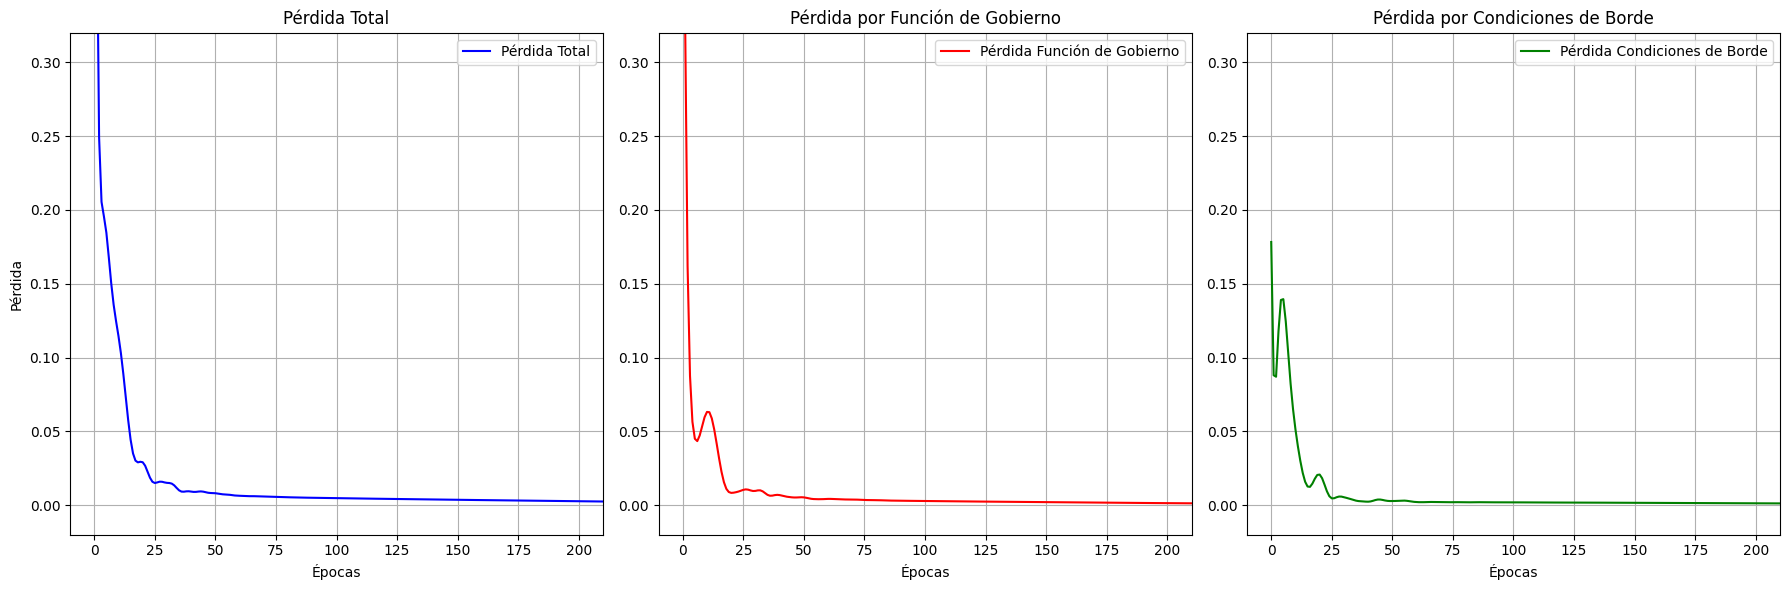

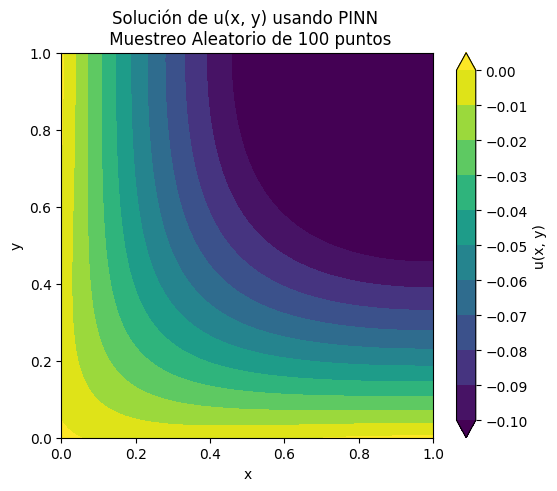

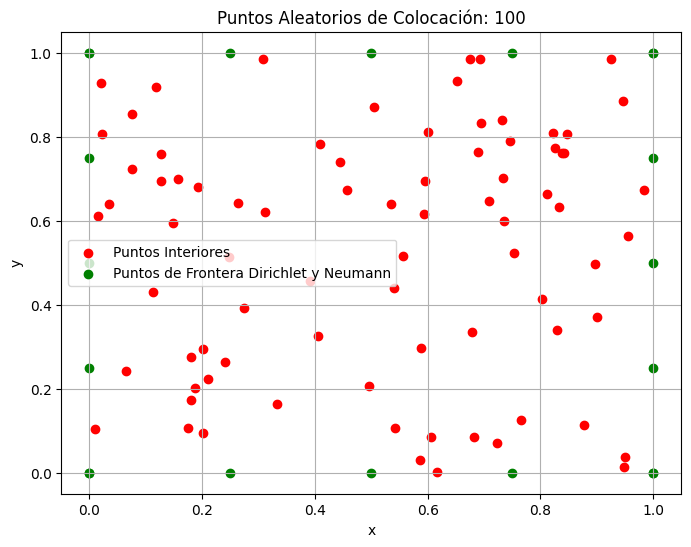

In [13]:
# Definición de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.model(x)

# Función de pérdida para el interior
def loss_fn(xy_interior):
    u = model(xy_interior)
    u_x = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_xx = torch.autograd.grad(u_x, xy_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, xy_interior, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    return torch.mean((laplace_u - source_term) ** 2)


# Función de pérdida para las condiciones de frontera
def boundary_loss(xy_boundary, boundary_type):
    u_boundary = model(xy_boundary)
    if boundary_type == "Dirichlet":
        return torch.mean((u_boundary) ** 2)
    elif boundary_type == "Neumann_x":
        u_x = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 0]
        return torch.mean((u_x) ** 2)
    elif boundary_type == "Neumann_y":
        u_y = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 1]
        return torch.mean((u_y) ** 2)

# Crear puntos del dominio
num_samples = 100  # Total de puntos
num_boundary_samples = int(0.20 * num_samples)  # 20% para la frontera
num_interior_samples = num_samples - num_boundary_samples  # 80% para el interior

# Crear puntos interiores
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras
x_vals = np.linspace(0, 1, 5)
y_vals = np.linspace(0, 1, 5)

xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)

# Crear el modelo y el optimizador
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 2000
losses_total = []
losses_interior = []
losses_boundary = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdida en el interior del dominio (función de gobierno)
    loss_interior = loss_fn(xy_interior_random)
    
    # Pérdidas de frontera (sin discriminar tipo)
    loss_boundary = (
        boundary_loss(xy_b0, "Dirichlet") +
        boundary_loss(xy_b1, "Dirichlet") +
        boundary_loss(xy_nx, "Neumann_x") +
        boundary_loss(xy_ny, "Neumann_y")
    )
    
    # Pérdida total
    loss = loss_interior + loss_boundary
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary.item())

    if epoch % 100 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar las pérdidas en subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pérdida total
axes[0].plot(losses_total, label="Pérdida Total", color="blue")
axes[0].set_title("Pérdida Total")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].grid(True)
axes[0].set_xlim([-10, 210])
axes[0].set_ylim([-0.02, 0.32])
axes[0].legend()

# Pérdida función de gobierno
axes[1].plot(losses_interior, label="Pérdida Función de Gobierno", color="red")
axes[1].set_title("Pérdida por Función de Gobierno")
axes[1].set_xlabel("Épocas")
axes[1].grid(True)
axes[1].set_xlim([-10, 210])
axes[1].set_ylim([-0.02, 0.32])
axes[1].legend()

# Pérdida condiciones de borde
axes[2].plot(losses_boundary, label="Pérdida Condiciones de Borde", color="green")
axes[2].set_title("Pérdida por Condiciones de Borde")
axes[2].set_xlabel("Épocas")
axes[2].grid(True)
axes[2].set_xlim([-10, 210])
axes[2].set_ylim([-0.02, 0.32])
axes[2].legend()

plt.tight_layout()
plt.show()

# Evaluar la solución del modelo en una grilla densa (1000x1000)
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
xy_eval = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
u_pred = model(xy_eval).detach().numpy().reshape(1000, 1000)

# Graficar la solución interpolada
plt.figure(figsize=(6, 5))
cp = plt.contourf(X, Y, u_pred, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Muestreo Aleatorio de 100 puntos")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Graficar los puntos de colocación aleatoria
plt.figure(figsize=(8, 6))

# Puntos interiores (rojos)
plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos Interiores')

# Puntos de frontera (verdes)
plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Puntos de Frontera Dirichlet y Neumann')
plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green')
plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='green')
plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='green')

# Configuraciones del gráfico
plt.title("Puntos Aleatorios de Colocación: 100")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### III - Cantidad de puntos de colocación aleatorios equivalente a grilla de 20x20.

Época 0, Pérdida total: 0.21671023964881897
Época 100, Pérdida total: 0.0038429000414907932
Época 200, Pérdida total: 0.0027726939879357815
Época 300, Pérdida total: 0.0021620376501232386
Época 400, Pérdida total: 0.0017625454347580671
Época 500, Pérdida total: 0.0012971418909728527
Época 600, Pérdida total: 0.0018198949983343482
Época 700, Pérdida total: 0.0009616923052817583
Época 800, Pérdida total: 0.0008096950477920473
Época 900, Pérdida total: 0.0007491742144338787
Época 1000, Pérdida total: 0.0006175111047923565
Época 1100, Pérdida total: 0.000513788836542517
Época 1200, Pérdida total: 0.0007744342437945306
Época 1300, Pérdida total: 0.0004326376074459404
Época 1400, Pérdida total: 0.00041212051291950047
Época 1500, Pérdida total: 0.00040414859540760517
Época 1600, Pérdida total: 0.0003990365657955408
Época 1700, Pérdida total: 0.00041469180723652244
Época 1800, Pérdida total: 0.00039551002555526793
Época 1900, Pérdida total: 0.00039019857649691403


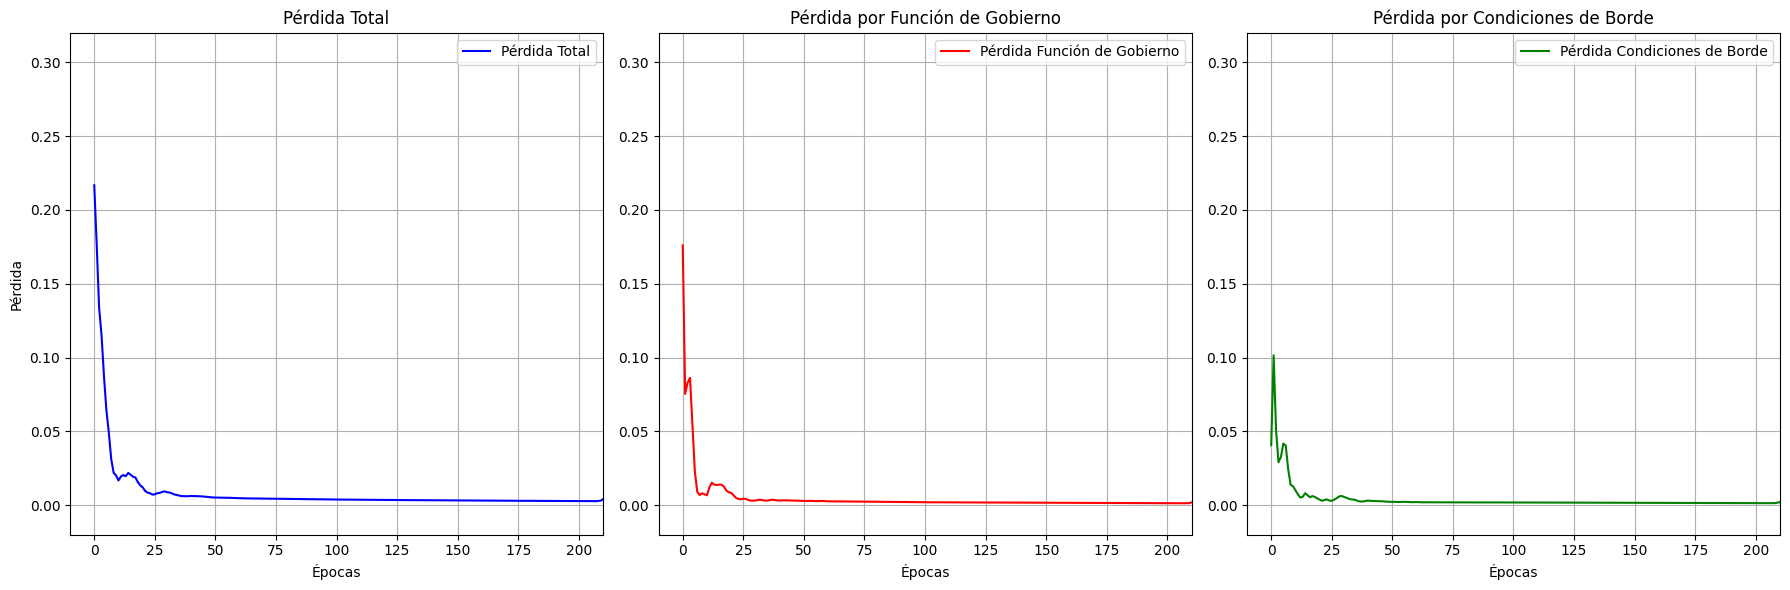

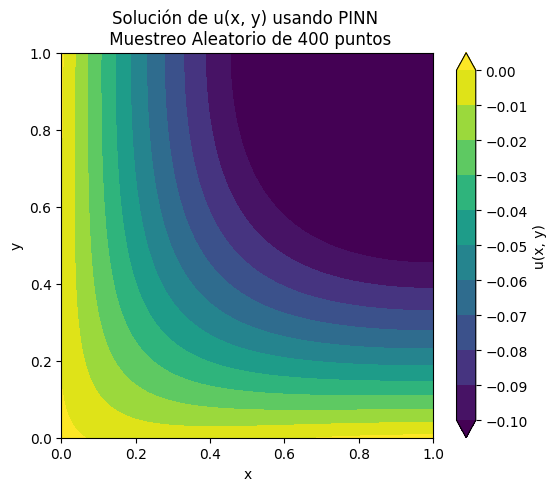

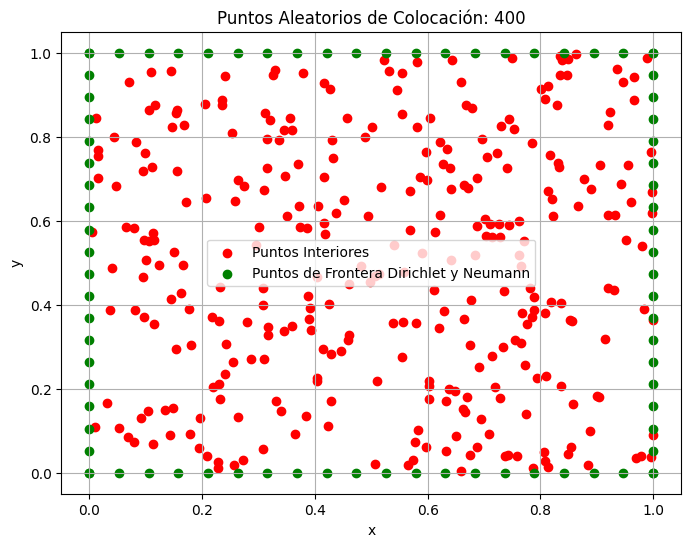

In [12]:
# Definición de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.model(x)

# Función de pérdida para el interior
def loss_fn(xy_interior):
    u = model(xy_interior)
    u_x = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_xx = torch.autograd.grad(u_x, xy_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, xy_interior, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    return torch.mean((laplace_u - source_term) ** 2)


# Función de pérdida para las condiciones de frontera
def boundary_loss(xy_boundary, boundary_type):
    u_boundary = model(xy_boundary)
    if boundary_type == "Dirichlet":
        return torch.mean((u_boundary) ** 2)
    elif boundary_type == "Neumann_x":
        u_x = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 0]
        return torch.mean((u_x) ** 2)
    elif boundary_type == "Neumann_y":
        u_y = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 1]
        return torch.mean((u_y) ** 2)

# Crear puntos del dominio
num_samples = 400  # Total de puntos
num_boundary_samples = int(0.20 * num_samples)  # 20% para la frontera
num_interior_samples = num_samples - num_boundary_samples  # 80% para el interior

# Crear puntos interiores
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)

xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)

# Crear el modelo y el optimizador
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 2000
losses_total = []
losses_interior = []
losses_boundary = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdida en el interior del dominio (función de gobierno)
    loss_interior = loss_fn(xy_interior_random)
    
    # Pérdidas de frontera (sin discriminar tipo)
    loss_boundary = (
        boundary_loss(xy_b0, "Dirichlet") +
        boundary_loss(xy_b1, "Dirichlet") +
        boundary_loss(xy_nx, "Neumann_x") +
        boundary_loss(xy_ny, "Neumann_y")
    )
    
    # Pérdida total
    loss = loss_interior + loss_boundary
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary.item())

    if epoch % 100 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar las pérdidas en subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pérdida total
axes[0].plot(losses_total, label="Pérdida Total", color="blue")
axes[0].set_title("Pérdida Total")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].grid(True)
axes[0].set_xlim([-10, 210])
axes[0].set_ylim([-0.02, 0.32])
axes[0].legend()

# Pérdida función de gobierno
axes[1].plot(losses_interior, label="Pérdida Función de Gobierno", color="red")
axes[1].set_title("Pérdida por Función de Gobierno")
axes[1].set_xlabel("Épocas")
axes[1].grid(True)
axes[1].set_xlim([-10, 210])
axes[1].set_ylim([-0.02, 0.32])
axes[1].legend()

# Pérdida condiciones de borde
axes[2].plot(losses_boundary, label="Pérdida Condiciones de Borde", color="green")
axes[2].set_title("Pérdida por Condiciones de Borde")
axes[2].set_xlabel("Épocas")
axes[2].grid(True)
axes[2].set_xlim([-10, 210])
axes[2].set_ylim([-0.02, 0.32])
axes[2].legend()

plt.tight_layout()
plt.show()

# Evaluar la solución del modelo en una grilla densa (1000x1000)
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
xy_eval = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
u_pred = model(xy_eval).detach().numpy().reshape(1000, 1000)

# Graficar la solución interpolada
plt.figure(figsize=(6, 5))
cp = plt.contourf(X, Y, u_pred, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Muestreo Aleatorio de 400 puntos")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Graficar los puntos de colocación aleatoria
plt.figure(figsize=(8, 6))

# Puntos interiores (rojos)
plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos Interiores')

# Puntos de frontera (verdes)
plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Puntos de Frontera Dirichlet y Neumann')
plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green')
plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='green')
plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='green')

# Configuraciones del gráfico
plt.title("Puntos Aleatorios de Colocación: 400")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()